In [1]:
import numpy
import matplotlib
import matplotlib.pyplot as mp
import pandas
import mpl_toolkits
from mpl_toolkits import basemap
import matplotlib.cm as cm
import netCDF4
import time
import itertools
import datetime
import scipy.stats

degree_sign = u'\u00B0'
mp.rcParams.update({'mathtext.default': 'regular'})
mp.rcParams['hatch.color'] = '0.5'

% matplotlib inline

In [2]:
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y))

In [3]:
# make color map
minval=0.05 # 
maxval=0.95 #
n=256
full_cmap = mp.get_cmap('RdBu')
cmap_partial = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap.name, a=minval, b=maxval), full_cmap(numpy.linspace(minval, maxval, n)))

In [4]:
SKIP_LONS = []#[120.,240.]
def format_every_other(lon):
    if lon in SKIP_LONS:
        return ''
    else:
        return '%3d' % lon + '\N{DEGREE SIGN}E' #r'${%3d\/^{\circ}\/E}$'%lon

In [5]:
whiplash_segments = numpy.array(( \
'1920-1950', \
'1950-1980', \
'1980-2010', \
'2010-2040', \
'2040-2070', \
'2070-2100', \
))

In [6]:
PRECT_lat = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lat.npy')
PRECT_lon = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lon.npy')

In [7]:
LA_lat = 34.0522
LA_lon = 118.2437 # deg west
LA_lon = 180. + (180-LA_lon)

Oroville_dam_lat = 39.5380
Oroville_dam_lon = 121.4831 # deg west
Oroville_dam_lon = 360 - Oroville_dam_lon

SF_lat = 37.7749
SF_lon = 122.4194
SF_lon = 360 - SF_lon

In [8]:
cali_coast_latlon_indices = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/coastal_latlon_array_indices_3x.npy')
cali_coast_latlon_indices_zip = [i for i in zip(cali_coast_latlon_indices[:,0], cali_coast_latlon_indices[:,1])]

cali_coast_latlon_indices_3d = cali_coast_latlon_indices.reshape((11,3,2))
#print(cali_coast_latlon_indices_3d[0,:,:])

In [9]:
PRECT_nlat = 26
PRECT_nlon = 25

latlon_indices = list(itertools.product(range(PRECT_nlat), range(PRECT_nlon)))
region = 'whole_domain'
window=30

# Added later to calculate significance

In [10]:
filename = '/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/calcs_and_plots/whiplash/calculations/seasonal_whiplash_PIC_low_to_high.nc'
ncfile = netCDF4.Dataset(filename, 'r', 'NetCDF4')
whiplash_events_pic = ncfile.variables['whiplash_events'][:]

filename = '/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/calcs_and_plots/whiplash/calculations/seasonal_whiplash_hist_rcp_low_to_high.nc'
ncfile = netCDF4.Dataset(filename, 'r', 'NetCDF4')
whiplash_events_hist_rcp = ncfile.variables['seasonal_total'][:]

(1798, 26, 25)


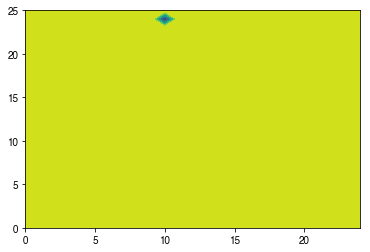

In [12]:
print(whiplash_events_pic.shape)
mp.contourf(whiplash_events_pic[0,:,:])

In [11]:
whiplash_count_pic = numpy.sum(whiplash_events_pic==1, axis=0)
whiplash_count_pic_mean = numpy.array(whiplash_count_pic)/1798.

# sum hist+rcp across ensemble members, then divide by 40
whiplash_count_hist_rcp = numpy.sum(whiplash_events_hist_rcp==1, axis=1)
whiplash_count_hist_rcp_mean = numpy.array(whiplash_count_hist_rcp)/40.

whiplash_ratios_change = 100*numpy.array((whiplash_count_hist_rcp==1) - whiplash_count_pic_mean)/(whiplash_count_pic_mean)
whiplash_ratios_mean = 100*whiplash_count_hist_rcp_mean/whiplash_count_pic_mean
whiplash_ratios = whiplash_count_hist_rcp/whiplash_count_pic_mean
#whiplash_ratios = numpy.array()

In [12]:
hist_rcp_counts_ALL_LATLON_smooth = numpy.zeros((whiplash_count_hist_rcp.shape))
for i in range(PRECT_nlat):
    for j in range(PRECT_nlon):
        hist_rcp_counts_ALL_LATLON_smooth[:,i,j] = pandas.Series(whiplash_count_hist_rcp[:,i,j]).rolling(window=window, center=True).mean()

pic_counts_ALL_LATLON_equivalent = whiplash_count_pic/(1798/40)
hist_rcp_counts_ALL_LATLON_smooth_norm = numpy.zeros((whiplash_count_hist_rcp.shape))
for i in range(PRECT_nlat):
    for j in range(PRECT_nlon):
        hist_rcp_counts_ALL_LATLON_smooth_norm[:,i,j] = (hist_rcp_counts_ALL_LATLON_smooth[:,i,j] - pic_counts_ALL_LATLON_equivalent[i,j])/pic_counts_ALL_LATLON_equivalent[i,j] * 100.

hist_rcp_counts_ALL_LATLON_smooth_ratios = numpy.zeros((whiplash_count_hist_rcp.shape))
for i in range(PRECT_nlat):
    for j in range(PRECT_nlon):
        hist_rcp_counts_ALL_LATLON_smooth_ratios[:,i,j] = hist_rcp_counts_ALL_LATLON_smooth[:,i,j]/pic_counts_ALL_LATLON_equivalent[i,j]

In [13]:
count_ratio_2d = hist_rcp_counts_ALL_LATLON_smooth_ratios[-15,:,:]
print(count_ratio_2d.shape)
#cf=mp.contourf(count_ratio_2d)
#mp.colorbar(cf)

(26, 25)


# Significance test (internal variability test on PIC)

In [14]:
whiplash_events_pic_alltime = numpy.array((whiplash_events_pic==1))
whiplash_events_pic_alltime_smooth = numpy.zeros((whiplash_events_pic_alltime.shape))*numpy.nan
for i in range(PRECT_nlat):
    for j in range(PRECT_nlon):
        whiplash_events_pic_alltime_smooth[:,i,j] = pandas.Series(whiplash_events_pic_alltime[:,i,j]).rolling(window=window, center=True).mean()
    
# calculate 30yr ratios of pic to itself
# divide 30yr rolling mean number of PIC events by the total average number of events per year for each grid point
# total average number per year is:
whiplash_events_pic_alltime_smooth_ratios = numpy.zeros((whiplash_events_pic_alltime_smooth.shape))
for t in range(whiplash_events_pic_alltime_smooth.shape[0]):
    whiplash_events_pic_alltime_smooth_ratios[t,:,:] = whiplash_events_pic_alltime_smooth[t,:,:]/whiplash_count_pic_mean

# calculate means across the coastal California latitudes
# then calculate pvalues of percentiles
whiplash_events_pic_alltime_smooth_ratios_cali_coast = whiplash_events_pic_alltime_smooth_ratios[:,cali_coast_latlon_indices[:,0],cali_coast_latlon_indices[:,1]]
whiplash_events_pic_alltime_smooth_ratios_cali_coast = numpy.reshape(whiplash_events_pic_alltime_smooth_ratios_cali_coast, (-1,11,3))
whiplash_events_pic_alltime_smooth_ratios_latmean = numpy.nanmean(whiplash_events_pic_alltime_smooth_ratios_cali_coast, axis=2).T
print(whiplash_events_pic_alltime_smooth_ratios_latmean.shape)


(11, 1798)


/Users/baird/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


1.00051114286


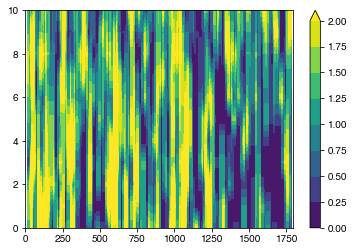

In [36]:
cf=mp.contourf(whiplash_events_pic_alltime_smooth_ratios_latmean, levels=numpy.arange(0.0, 2.1, 0.25), extend='max')
mp.colorbar(cf)
print(numpy.nanmean(whiplash_events_pic_alltime_smooth_ratios_latmean))

In [39]:
all_wr_data_2d_cali_coast = hist_rcp_counts_ALL_LATLON_smooth_ratios[:,cali_coast_latlon_indices[:,0],cali_coast_latlon_indices[:,1]]
all_wr_data_2d_cali_coast = numpy.reshape(all_wr_data_2d_cali_coast, (-1,11,3))
all_wr_data_cali_coast_latmean = numpy.nanmean(all_wr_data_2d_cali_coast, axis=2).T

/Users/baird/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [40]:
print(all_wr_data_cali_coast_latmean.shape)

(11, 180)


In [58]:
ratios_to_test = all_wr_data_cali_coast_latmean
pvals_wr_time_lat = numpy.zeros((all_wr_data_cali_coast_latmean.shape))
for i in range(11):
    for t in range(180):
        pvals_wr_time_lat[i,t] = scipy.stats.percentileofscore( whiplash_events_pic_alltime_smooth_ratios_latmean[i,:], ratios_to_test[i,t])#, kind='weak')
pvals_wr_time_lat /= 100.
pvals_wr_time_lat = 1-pvals_wr_time_lat

/Users/baird/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/baird/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [59]:
print(all_wr_data_cali_coast_latmean.shape)

(11, 180)


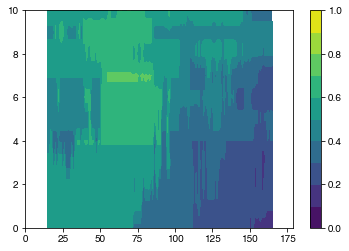

In [60]:
cf=mp.contourf(pvals_wr_time_lat, levels=numpy.arange(0,1.1,0.1))
mp.colorbar(cf)

# New version (October 28)

In [61]:
year_list = numpy.arange(1921,2101)

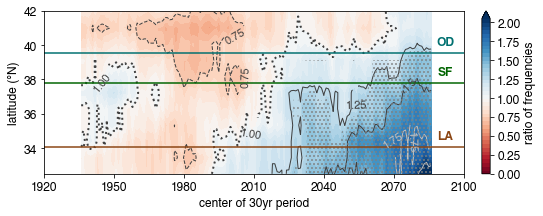

In [62]:
fontsize=12

fig = mp.figure(figsize=(8,3))

ax = fig.add_subplot(111)

contour_levels = numpy.arange(0,2.1,0.05)

ax_cf = ax.contourf(year_list, \
                    PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
                    all_wr_data_cali_coast_latmean, \
                    norm=MidpointNormalize(midpoint=1.0), \
                    cmap='RdBu', \
                    levels=contour_levels, \
                    extend='max')

ax_sig = ax.contourf(year_list, \
                    PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
                    pvals_wr_time_lat, \
                    #count_ratio_2d_cali_bool, \
                    colors='None', \
                    levels=[0.0,0.333,1.0], \
                    #levels=[0.5,1.5], \
                    hatches=['...',None], \
                    extend='lower', \
                    edgecolors='red', \
                    zorder=2)

ax_c = ax.contour(year_list, \
                    PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
                    all_wr_data_cali_coast_latmean, \
                    norm=MidpointNormalize(midpoint=1.0), \
                    levels=[0,0.25,0.5,0.75,1,1.25,1.5,1.75,2], \
                    colors=['0.25']*7+['0.75']*2, \
                    linestyles=['--']*4+[':']+['-']*4, \
                    linewidths=[1]*4+[2]+[1]*4, \
                    zorder=1)

new_levels = []
for i in ax_c.levels:
    if i in [0.5,1.5]:
        new_levels.append('{:.1f}'.format(i))
    else:
        new_levels.append('{:.2f}'.format(i))
ax_c.levels = new_levels
mp.clabel(ax_c, fontsize=fontsize-1, colors=['0.25']*7+['0.75']*2)

la_color = 'saddlebrown'
sf_color = 'darkgreen'
od_color = '#007070' # '#008080' is teal

#ax.axhline(LA_lat, c='firebrick', zorder=1)
ax.axhline(LA_lat, c=la_color, zorder=2)
ax.axhline(SF_lat, c=sf_color, zorder=2)
ax.axhline(Oroville_dam_lat, c=od_color, zorder=2)

ax.text(s='LA', zorder=3, x=2092, y=LA_lat+0.3, color=la_color, ha='center', va='bottom', fontsize=fontsize, weight='bold')
ax.text(s='SF', zorder=3, x=2092, y=SF_lat+0.3, color=sf_color, ha='center', va='bottom', fontsize=fontsize, weight='bold')
ax.text(s='OD', zorder=3, x=2092, y=Oroville_dam_lat+0.3, color=od_color, ha='center', va='bottom', fontsize=fontsize, weight='bold')

ax.set_xlim(1920,2100)
ax.set_xticks(numpy.arange(1920,2101,30))
ax.set_yticks(numpy.arange(34,43,2))

ax.tick_params(labelsize=fontsize)

ax.set_ylabel('latitude ('+degree_sign+'N)', fontsize=fontsize)
ax.set_xlabel('center of 30yr period', fontsize=fontsize)

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('right', size='2%', pad=0.25) #fig.add_axes([0.0, -0.02, 1.0, 0.03])
cbar = fig.colorbar(ax_cf, cax=cbar_ax, orientation='vertical')
cbar.set_label('ratio of frequencies', fontsize=fontsize)#, labelpad=10)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_ticks([0,0.25,0.5,0.75,1,1.25,1.5,1.75,2])

#cf = mp.contourf(year_middle_list, PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], count_ratio_2d_cali)
#mp.colorbar(cf)

#fig.savefig('time_latitude_plot.pdf', transparent=True, bbox_inches='tight')

In [63]:
PRECT_lat_subset = PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])]

In [65]:
# convert times
time_datetime = [datetime.datetime(i,1,15) for i in year_list]
time_nc = netCDF4.date2num(time_datetime, units='days since 1920-01-01', calendar='standard')

In [69]:
# save hist clim
filename = 'time_latitude_whiplash_ratios_8020_updated.nc'

ncfile = netCDF4.Dataset(filename, 'w', format='NETCDF4')

lat_dim = ncfile.createDimension('lat', PRECT_lat_subset.size)
time_dim = ncfile.createDimension('time', len(year_list))

lat_var = ncfile.createVariable('lat', 'f4', ('lat',))
time_var = ncfile.createVariable('time', 'f4', ('time',))
lat_var[:] = PRECT_lat_subset
time_var[:] = time_nc
lat_var.units = 'degrees_north'
time_var.units = 'days since 1920-01-01'
time_var.description = 'Each year is centered on the 30 years surrounding it'

ratios_of_frequencies = ncfile.createVariable('time_lat_ratios', 'f4', ('lat','time'), fill_value=numpy.nan)
ratios_of_frequencies[:] = all_wr_data_cali_coast_latmean
ratios_of_frequencies.units = 'unitless'
ratios_of_frequencies.description = 'Ratio of frequencies of whiplash events for California grid points (average of 3 grid points for each latitude)'

sigtest_pvals = ncfile.createVariable('sigtest_pvals', 'f4', ('lat','time'), fill_value=numpy.nan)
sigtest_pvals[:] = pvals_wr_time_lat
sigtest_pvals.description = 'Calculated across 1798 years of pre-industrial control.  A value of 0.2 means significance at the 80% confidence level'

ncfile.history = 'Created ' + time.ctime(time.time())
ncfile.close()
print(filename, "saved")

time_latitude_whiplash_ratios_8020_updated.nc saved
